# CSCI 8523 Fall 2022 - predicting global crop yields from MODIS
Tim Bodin, Maitrayee Deka, Varun Sethi, Josh Spitzer-Resnick

## resources

Implementing LSTM
- https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
- https://cnvrg.io/pytorch-lstm/
- https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
- https://wandb.ai/sauravmaheshkar/LSTM-PyTorch/reports/Using-LSTM-in-PyTorch-A-Tutorial-With-Examples--VmlldzoxMDA2NTA5
- https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
- https://github.com/AnnaXWang/deep-transfer-learning-crop-prediction
  - from Deep Transfer Learning for Crop Yield Prediction with Remote Sensing Data ([2018](https://dl.acm.org/doi/10.1145/3209811.3212707))
- https://www.crosstab.io/articles/time-series-pytorch-lstm/
- https://towardsdatascience.com/pytorch-lstms-for-time-series-data-cd16190929d7
- https://towardsdatascience.com/building-rnn-lstm-and-gru-for-time-series-using-pytorch-a46e5b094e7b
- https://www.crosstab.io/articles/time-series-pytorch-lstm/
- https://towardsdatascience.com/lstm-and-bidirectional-lstm-for-regression-4fddf910c655

Binnning strategies
- 1: observations/year x bins (0 to 1 at 0.05 step) x metric/index/band (NDVI)
  - (365/16 ~= 23) x 20 (x 1) (matrix)
- 2: observations/year x bins (0 to 1 at 0.05 step) x metric/index/band (NDVI) x 50 states
  - (365/16 ~= 23) x 20 (x 1) x 50 (tensor)
- 3: observations/year x bins (0 to 1 at 0.05 step) x metric/index/band (NDVI, EWI, 1/red, 2/NIR, 3/blue, 7/MIR)
  - (365/16 ~= 23) x 20 x 6 (tensor)

Data
- 20 + 21*23 + 17 = 520 observations
  - 2000: day 49-353 (20 observations)
  - 2001-2021 (21 years): day 1-353 (23 observations)
  - 2022: day 1-257 (17 observations)
- binning options
  - full year for 2001-2021 (21 years)
    - day 1-353 (23 observations) Jan 1 - Dec 19 (non leap year)
  - max length for 2000-2022 (23 years) which removes winter
    - day 49-257 (14 observations) Feb 18 - Sept 14 (non leap year)
    - might get day 273 to make 15 observations until Sept 30 (non leap year)
  - Tim: It looks like the correlation becomes "relevant" starting end May or early June (ie, starting period 145). 273 would be a good cutoff, but I can't seem to get it (working on it). Suggest you use 145-247 for high sensitivity for CORN and SB. Wheat might be sensitive earlier.
    - day 145-247 (8 observations) May 25 - Sept 14 (non leap year)
  - or just try day 209 histogram

Cross validation
- leave out 2012 (drought)
- leave out 2022 (just October estimate of final)
- leave out last 20%, first 20%, alternate throughout years

Evalutation
- RMSE is unit sensitive - use R^2 (percent variation in model - r is coef of determination)
- perfect model has r^2 of 1, useless has r^2 of 0
- normalized statistics can be used to
- ( pred - actual(test) ) ^2 / (deviation of y from mean = actual - mean)
- similar but normalizing it
- RMSE / mean of y or 1 minus that might be equal
- R^2 is accuracy measure, RMSE is error measure

## 1 imports

In [ ]:
# imports
from google.colab import drive # drive.mount
# import os # os.scandir
import pandas as pd
# from pyhdf.SD import SD, SDC # scientific dataset # documentation https://github.com/fhs/pyhdf/blob/master/pyhdf/SD.py
from matplotlib import pyplot as plt
import numpy as np # np.load # NOPE np.linalg.norm
from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## 2 break modisUSA.npy into years

### 2.1 slicing

In [ ]:
modis_file = '/content/drive/Shareddrives/CSCI 8523 F22/Data/PhaseI/modisUSA.npy'

In [ ]:
modis_array = np.load(modis_file)

In [ ]:
modis_array.shape

(460, 1115, 520)

In [ ]:
# 2000
modis_array[:, :, :20].shape

(460, 1115, 20)

In [ ]:
# 2022
modis_array[:, :, -17:].shape # 17 from end
modis_array[:, :, 503:].shape # equivalent

(460, 1115, 17)

In [ ]:
# 2001-2021
modis_array[:, :, 20:503].shape # includes start, exlcudes end

(460, 1115, 483)

In [ ]:
modis_array[:, :, 20:(20+23)].shape

(460, 1115, 23)

In [ ]:
modis_array.max()

0.9913

### 2.2 data structure for years

In [ ]:
# modis_per_year = { {}... }
# year (int)
# ... observations - all, inconsistent number for first and last
# ... observations_49_257 - 14 observations, consistent for each year
# ... bins(_10) - list of all observations in years as bins
# ... bins(_20)
# ... label - yield as float

years = list(range(2000, 2023)) # 2000-2022

In [ ]:
modis_per_year = { year:{} for year in years } # year as key (int)

In [ ]:
# irregular
modis_per_year[2000]['observations'] = modis_array[:, :, :20] # indices 0-19 (20)
modis_per_year[2022]['observations'] = modis_array[:, :, 503:] # indices 503-519 (17)

In [ ]:
observation_index = 20 # start at 21st observation
for year in range(2001, 2022): # until 2021
  print('year, observation indices', year, observation_index, observation_index+23)
  modis_per_year[year]['observations'] = modis_array[:, :, observation_index:(observation_index+23)]
  observation_index += 23

year, observation indices 2001 20 43
year, observation indices 2002 43 66
year, observation indices 2003 66 89
year, observation indices 2004 89 112
year, observation indices 2005 112 135
year, observation indices 2006 135 158
year, observation indices 2007 158 181
year, observation indices 2008 181 204
year, observation indices 2009 204 227
year, observation indices 2010 227 250
year, observation indices 2011 250 273
year, observation indices 2012 273 296
year, observation indices 2013 296 319
year, observation indices 2014 319 342
year, observation indices 2015 342 365
year, observation indices 2016 365 388
year, observation indices 2017 388 411
year, observation indices 2018 411 434
year, observation indices 2019 434 457
year, observation indices 2020 457 480
year, observation indices 2021 480 503


In [ ]:
modis_per_year.keys() # modis_per_year[2000].keys()

dict_keys([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

### binning - OLD, one set of bins each time

In [ ]:
# parameters
BINS = 5 # 10 # 20
MAX_VAL = 1 # modisUSA.npy already normalized
MIN_VAL = 0

In [ ]:
# bins then image - O(bins*height*weight unless mark which pixels already sorted)
# image then bins - stop iterating through bins when found appropriate - faster

def get_bins_from_observation(modis_observation, bins, max_val, min_val):
  # expect a matrix of height x width
  binned_observation = np.zeros(bins)
  increment = (max_val - min_val) / bins

  height, width = modis_observation.shape
  # print('height, width, pixels', height, width, height*width)

  # """
  # bins then image - search all pixels for each bin (slower)
  # size of image >> bins - iterate through image once for each bin
  for bin_i in range(bins): # tqdm(range(bins)):
    # print(bin_i, bin_i*increment, (bin_i+1)*increment) # floating point error, maybe should just hard code it?

    # iterate through image, place pixels in given bin
    for row in range(height):
      for col in range(width):
        # iterate through image once for each bin
        if modis_observation[row, col] != 0: # don't want fill values
          if (modis_observation[row, col] >= bin_i*increment) and (modis_observation[row, col] < (bin_i+1)*increment):
            binned_observation[bin_i] += 1
  # """

  """
  # image then bins - stop when find correct bin (faster unless all values in last bin)
  # iterate through image, place pixels in given bin
  for row in range(height):
    for col in range(width):

      # iterate through bins until once until find correct for each pixel
      for bin_i in range(bins): # tqdm(range(bins)):
        # print(bin_i, bin_i*increment, (bin_i+1)*increment) # floating point error, maybe should just hard code it?

        if modis_observation[row, col] != 0: # don't want fill values
          if (modis_observation[row, col] >= bin_i*increment) and (modis_observation[row, col] < (bin_i+1)*increment):
            binned_observation[bin_i] += 1
            break
  """

  return binned_observation # array of size bins

In [ ]:
# 7sec 20 bins then image
# 4sec image then 20 bins
binned_modis = get_bins_from_observation(modis_per_year[2000]['observations'][:, :, 0], bins=BINS, max_val=MAX_VAL, min_val=MIN_VAL)
binned_modis

array([3.7210e+03, 5.0755e+04, 8.9870e+03, 6.4900e+02, 1.0000e+00])

In [ ]:
binned_modis.sum() # worked ok with floating point error (reduced when remove 0s)

64113.0

In [ ]:
modis_per_year[2000]['observations'][:, :, 0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
3*0.05

0.15000000000000002

In [ ]:
# make bins for a year of observations
def process_bins_batch(modis_observations_batch, bins, max_val, min_val):
  _, _, num_observations = modis_observations_batch.shape
  # print(num_observations)
  binned_observations_list = []

  for obs_i in tqdm(range(num_observations)):
    binned_observation = get_bins_from_observation(modis_observations_batch[:, :, obs_i], bins=bins, max_val=max_val, min_val=min_val)
    binned_observations_list.append(binned_observation)

  return binned_observations_list # list of arrays of bins

In [ ]:
# 20 observations - year 2000
# bins then image
#   20 bins - 2min
#   10 bins - 55sec-1min
#   5 bins - 29-30sec
# image then bins
#   20 bins - 1min 51sec
#   10 bins - 56sec
batch_binned_modis = process_bins_batch(modis_per_year[2000]['observations'], bins=BINS, max_val=MAX_VAL, min_val=MIN_VAL)
batch_binned_modis

20


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]


[array([3.7210e+03, 5.0755e+04, 8.9870e+03, 6.4900e+02, 1.0000e+00]),
 array([2.9360e+03, 4.9920e+04, 1.0363e+04, 1.1210e+03, 1.0000e+00]),
 array([2.0890e+03, 4.5075e+04, 1.4940e+04, 2.3040e+03, 4.0000e+00]),
 array([1.5280e+03, 4.1223e+04, 1.8499e+04, 3.2380e+03, 6.0000e+00]),
 array([  485., 33565., 25101.,  5302.,    42.]),
 array([   94., 20688., 29745., 13825.,   143.]),
 array([  121., 15093., 33378., 15788.,   115.]),
 array([1.5000e+01, 6.6820e+03, 3.2406e+04, 2.5079e+04, 3.1300e+02]),
 array([4.0000e+01, 3.6080e+03, 1.1501e+04, 4.4582e+04, 4.7640e+03]),
 array([   82.,  3362.,  8758., 29860., 22433.]),
 array([  189.,  3589.,  8947., 23499., 28271.]),
 array([  403.,  6034., 12406., 26810., 18842.]),
 array([  380.,  8343., 14887., 36215.,  4670.]),
 array([  638., 13993., 30788., 18661.,   415.]),
 array([5.7700e+02, 3.0233e+04, 2.4308e+04, 9.3720e+03, 5.0000e+00]),
 array([  455., 42861., 20030.,  1149.,     0.]),
 array([ 3908., 35816., 21675.,  1188.,     0.]),
 array([12

In [ ]:
np.arange(0,1,step=1/BINS)

array([0. , 0.2, 0.4, 0.6, 0.8])

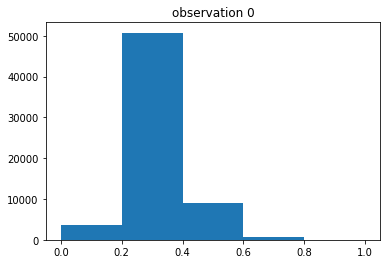

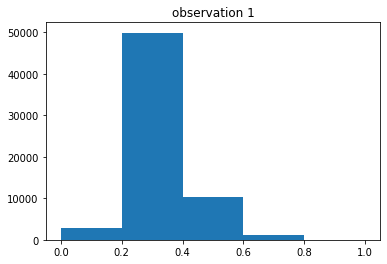

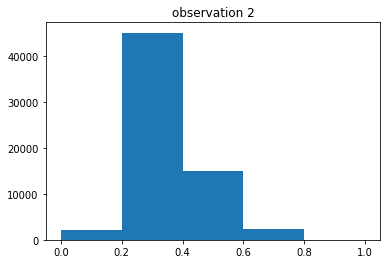

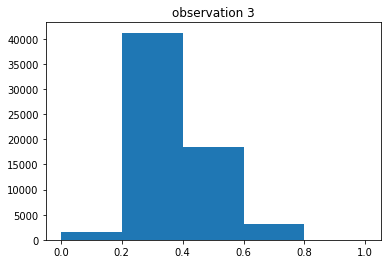

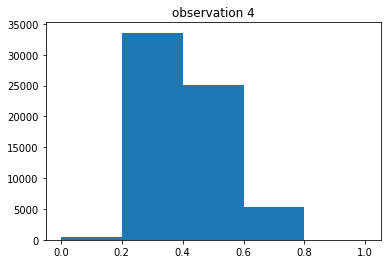

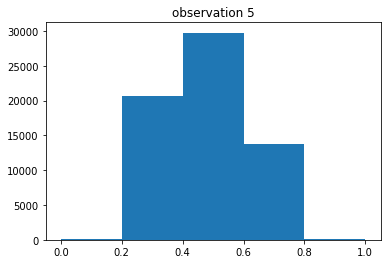

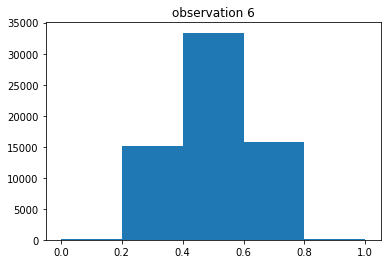

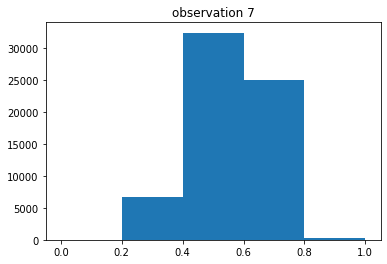

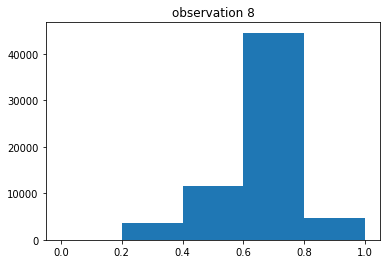

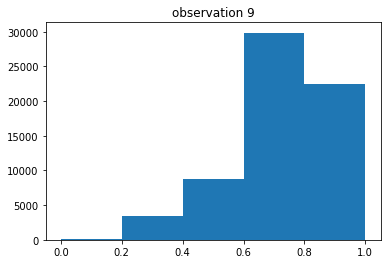

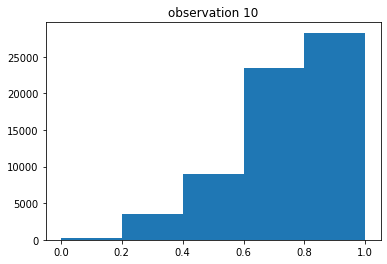

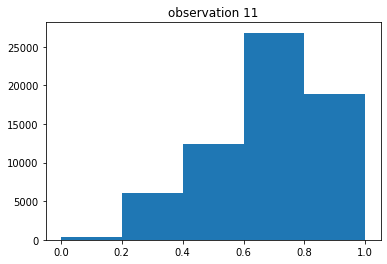

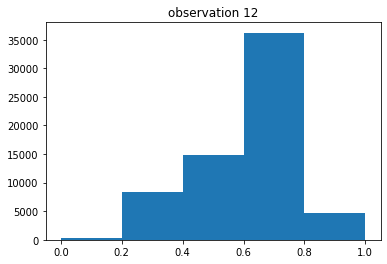

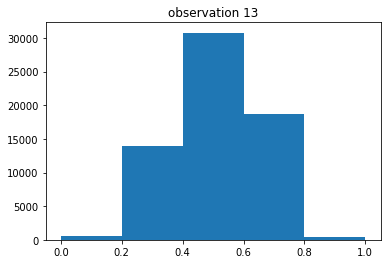

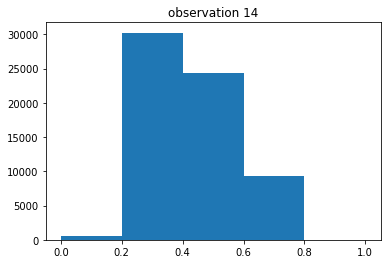

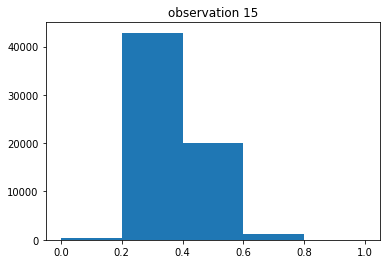

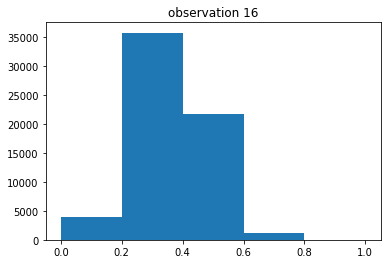

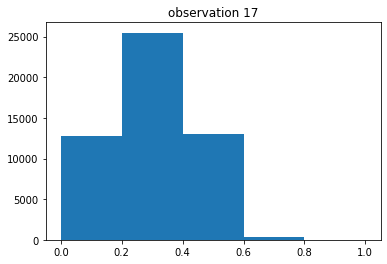

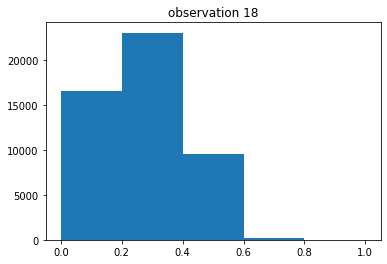

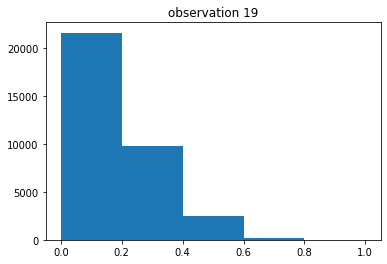

In [ ]:
for obs_i in range(len(batch_binned_modis)):
  plt.bar(np.arange(0,1,step=1/BINS), batch_binned_modis[obs_i], align='edge', width=1/BINS)
  plt.title('observation ' + str(obs_i))
  plt.show()
# plt.hist(np.arange(0,1,step=1/10), batch_binned_modis[0])

In [ ]:
# place all bins in data structure - should take ~23min for 10 bins

# bins then image
#   20 bins -
#   10 bins -
#   5 bins - 13min 34sec
# image then bins
#   20 bins -
#   10 bins -
for year in tqdm(range(2000, 2023)): # until 2022
  binned_observations = process_bins_batch(modis_per_year[year]['observations'], bins=BINS, max_val=MAX_VAL, min_val=MIN_VAL)
  key = 'bins_' + str(BINS)
  modis_per_year[year][key] = binned_observations

  0%|          | 0/23 [00:00<?, ?it/s]

20



  4%|▍         | 1/23 [00:30<11:17, 30.82s/it]

23



  9%|▊         | 2/23 [01:05<11:29, 32.81s/it]

23



 13%|█▎        | 3/23 [01:40<11:18, 33.92s/it]

23



 17%|█▋        | 4/23 [02:14<10:44, 33.90s/it]

23



 22%|██▏       | 5/23 [02:49<10:22, 34.60s/it]

23



 26%|██▌       | 6/23 [03:26<09:58, 35.22s/it]

23



 30%|███       | 7/23 [04:12<10:20, 38.79s/it]

23



 35%|███▍      | 8/23 [04:44<09:07, 36.52s/it]

23



 39%|███▉      | 9/23 [05:20<08:29, 36.37s/it]

23



 43%|████▎     | 10/23 [05:53<07:40, 35.46s/it]

23



 48%|████▊     | 11/23 [06:36<07:32, 37.67s/it]

23



 52%|█████▏    | 12/23 [07:11<06:45, 36.85s/it]

23



 57%|█████▋    | 13/23 [07:45<05:59, 35.96s/it]

23



 61%|██████    | 14/23 [08:21<05:23, 35.91s/it]

23



 65%|██████▌   | 15/23 [08:53<04:38, 34.82s/it]

23



 70%|██████▉   | 16/23 [09:34<04:16, 36.70s/it]

23



 74%|███████▍  | 17/23 [10:12<03:42, 37.03s/it]

23



 78%|███████▊  | 18/23 [10:50<03:07, 37.47s/it]

23



 83%|████████▎ | 19/23 [11:27<02:28, 37.23s/it]

23



 87%|████████▋ | 20/23 [12:01<01:48, 36.21s/it]

23



 91%|█████████▏| 21/23 [12:34<01:10, 35.49s/it]

23



 96%|█████████▌| 22/23 [13:09<00:35, 35.12s/it]

17



100%|██████████| 23/23 [13:34<00:00, 35.43s/it]


### 2.3 binning - NEW, avg, bin = 5, 10, 20 at the same time

In [ ]:
MAX_VAL = 1 # modisUSA.npy already normalized
MIN_VAL = 0

def get_avg_and_5_10_20_bins_from_observation(modis_observation, max_val, min_val):
  count = 0 # keep track of valid pixels != 0
  sum = 0 # values of valid pixels
  avg = 0 # sum/count at end

  binned_observation_5 = np.zeros(5)
  binned_observation_10 = np.zeros(10)
  binned_observation_20 = np.zeros(20)

  increment_5 = (max_val - min_val) / 5
  increment_10 = (max_val - min_val) / 10
  increment_20 = (max_val - min_val) / 20

  # expect a matrix of height x width
  height, width = modis_observation.shape
  """
  print('height, width, pixels', height, width, height*width)
  print('min, max', modis_observation.min(), modis_observation.max())
  """

  # image then avg and bins
  for row in range(height):
    for col in range(width):
      if modis_observation[row, col] != 0: # don't want fill values
        count += 1
        sum += modis_observation[row, col]

        # icky hardcoded, only works because increments evenly fit
        # iterate through 20 bins until find correct for each pixel
        for bin_i in range(20):
          if (modis_observation[row, col] >= bin_i*increment_20) and (modis_observation[row, col] < (bin_i+1)*increment_20): # lower bound inclusive, upper exclusive
            binned_observation_20[bin_i] += 1
            binned_observation_10[ int(bin_i/2) ] += 1
            binned_observation_5[ int(bin_i/4) ] += 1
            break
  
  avg = sum / count
  print('count, sum, avg', count, sum, avg)

  return avg, binned_observation_5, binned_observation_10, binned_observation_20

In [ ]:
for bin_20_i in range(20):
  print(bin_20_i, int(bin_20_i / 2), int(bin_20_i / 4))

0 0 0
1 0 0
2 1 0
3 1 0
4 2 1
5 2 1
6 3 1
7 3 1
8 4 2
9 4 2
10 5 2
11 5 2
12 6 3
13 6 3
14 7 3
15 7 3
16 8 4
17 8 4
18 9 4
19 9 4


In [ ]:
binned_modis = get_avg_and_5_10_20_bins_from_observation(modis_per_year[2000]['observations'][:, :, 9], max_val=MAX_VAL, min_val=MIN_VAL)
binned_modis

height, width, pixels 460 1115 512900
min, max 0.0 0.913
count, sum, avg 64495 46154.03679999957 0.7156219365842247


(0.7156219365842247,
 array([   82.,  3362.,  8758., 29860., 22433.]),
 array([    0.,    82.,   948.,  2414.,  3815.,  4943.,  8671., 21189.,
        22305.,   128.]),
 array([0.0000e+00, 0.0000e+00, 2.0000e+00, 8.0000e+01, 3.8400e+02,
        5.6400e+02, 9.6300e+02, 1.4510e+03, 1.7520e+03, 2.0630e+03,
        2.2340e+03, 2.7090e+03, 3.5690e+03, 5.1020e+03, 8.2560e+03,
        1.2933e+04, 1.4571e+04, 7.7340e+03, 1.2800e+02, 0.0000e+00]))

In [ ]:
# make avg, 5, 10, 20 bins for a year of observations
def process_avg_and_5_10_20_bins_batch(modis_observations_batch, max_val, min_val):
  _, _, num_observations = modis_observations_batch.shape
  print('num_observations', num_observations)
  binned_observations_list = []

  for obs_i in range(num_observations): # tqdm(range(num_observations)):
    binned_observation = get_avg_and_5_10_20_bins_from_observation(modis_observations_batch[:, :, obs_i], max_val=max_val, min_val=min_val)
    binned_observations_list.append(binned_observation)

  return binned_observations_list # list of tuples of (avg, arrays of 5, 10, 20 bins)

In [ ]:
# 15sec for 20 observations
# wow this is so much faster because I'm filtering out pixels with NDVI 0 rather than looping through bins for them as well
batch_binned_modis = process_avg_and_5_10_20_bins_batch(modis_per_year[2000]['observations'], max_val=MAX_VAL, min_val=MIN_VAL)
batch_binned_modis

num_observations 20


  0%|          | 0/20 [00:00<?, ?it/s]

height, width, pixels 460 1115 512900
min, max 0.0 0.8064


  5%|▌         | 1/20 [00:00<00:12,  1.49it/s]

count, sum, avg 64113 19213.01730000008 0.299674282906744
height, width, pixels 460 1115 512900
min, max 0.0 0.8022


 10%|█         | 2/20 [00:01<00:12,  1.45it/s]

count, sum, avg 64341 19905.591799999853 0.30937647534231444
height, width, pixels 460 1115 512900
min, max 0.0 0.8191


 15%|█▌        | 3/20 [00:02<00:12,  1.41it/s]

count, sum, avg 64412 21886.207599999932 0.33978463019313065
height, width, pixels 460 1115 512900
min, max 0.0 0.8249


 20%|██        | 4/20 [00:02<00:11,  1.41it/s]

count, sum, avg 64494 23364.553099999917 0.3622748333178267
height, width, pixels 460 1115 512900
min, max 0.0 0.8619


 25%|██▌       | 5/20 [00:03<00:10,  1.39it/s]

count, sum, avg 64495 26222.598300000085 0.4065834297232357
height, width, pixels 460 1115 512900
min, max 0.0 0.8775


 30%|███       | 6/20 [00:04<00:10,  1.35it/s]

count, sum, avg 64495 30965.83859999977 0.4801277401348906
height, width, pixels 460 1115 512900
min, max 0.0 0.8568


 35%|███▌      | 7/20 [00:05<00:09,  1.32it/s]

count, sum, avg 64495 32425.192500000005 0.5027551360570588
height, width, pixels 460 1115 512900
min, max 0.0 0.8689


 40%|████      | 8/20 [00:05<00:09,  1.27it/s]

count, sum, avg 64495 35737.41500000042 0.5541114039848116
height, width, pixels 460 1115 512900
min, max 0.0 0.9045


 45%|████▌     | 9/20 [00:06<00:09,  1.19it/s]

count, sum, avg 64495 42749.29979999951 0.6628312241258937
height, width, pixels 460 1115 512900
min, max 0.0 0.913


 50%|█████     | 10/20 [00:07<00:08,  1.11it/s]

count, sum, avg 64495 46154.03679999957 0.7156219365842247
height, width, pixels 460 1115 512900
min, max 0.0 0.9212


 55%|█████▌    | 11/20 [00:08<00:08,  1.09it/s]

count, sum, avg 64495 46579.99889999977 0.7222265121327199
height, width, pixels 460 1115 512900
min, max 0.0 0.9001


 60%|██████    | 12/20 [00:09<00:07,  1.09it/s]

count, sum, avg 64495 43486.934000000074 0.674268299868208
height, width, pixels 460 1115 512900
min, max 0.0 0.9056


 65%|██████▌   | 13/20 [00:10<00:06,  1.10it/s]

count, sum, avg 64495 40074.852199999994 0.6213637057136211
height, width, pixels 460 1115 512900
min, max 0.0 0.8386


 70%|███████   | 14/20 [00:11<00:05,  1.12it/s]

count, sum, avg 64495 33055.77409999992 0.5125323528955721
height, width, pixels 460 1115 512900
min, max 0.0 0.8289


 75%|███████▌  | 15/20 [00:12<00:04,  1.16it/s]

count, sum, avg 64495 27972.200299999848 0.4337111450500015
height, width, pixels 460 1115 512900
min, max 0.0 0.7526


 80%|████████  | 16/20 [00:13<00:03,  1.22it/s]

count, sum, avg 64495 23397.96789999989 0.36278731529575764
height, width, pixels 460 1115 512900
min, max 0.0 0.7564


 85%|████████▌ | 17/20 [00:13<00:02,  1.25it/s]

count, sum, avg 62587 22733.234799999875 0.3632261460047594
height, width, pixels 460 1115 512900
min, max 0.0 0.7262


 90%|█████████ | 18/20 [00:14<00:01,  1.36it/s]

count, sum, avg 51644 14680.013700000083 0.284254002401055
height, width, pixels 460 1115 512900
min, max 0.0 0.7249


 95%|█████████▌| 19/20 [00:14<00:00,  1.47it/s]

count, sum, avg 49330 12390.410900000034 0.25117394891546796
height, width, pixels 460 1115 512900
min, max 0.0 0.9898


100%|██████████| 20/20 [00:15<00:00,  1.30it/s]

count, sum, avg 34122 4851.992000000026 0.14219541644686787


[(0.299674282906744,
  array([3.7210e+03, 5.0755e+04, 8.9870e+03, 6.4900e+02, 1.0000e+00]),
  array([6.3300e+02, 3.0880e+03, 3.5146e+04, 1.5609e+04, 6.3020e+03,
         2.6850e+03, 5.6700e+02, 8.2000e+01, 1.0000e+00, 0.0000e+00]),
  array([3.5200e+02, 2.8100e+02, 3.6100e+02, 2.7270e+03, 2.0987e+04,
         1.4159e+04, 9.8930e+03, 5.7160e+03, 3.7850e+03, 2.5170e+03,
         1.7250e+03, 9.6000e+02, 4.0100e+02, 1.6600e+02, 6.3000e+01,
         1.9000e+01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])),
 (0.30937647534231444,
  array([2.9360e+03, 4.9920e+04, 1.0363e+04, 1.1210e+03, 1.0000e+00]),
  array([4.5700e+02, 2.4790e+03, 3.4495e+04, 1.5425e+04, 7.0530e+03,
         3.3100e+03, 1.0050e+03, 1.1600e+02, 1.0000e+00, 0.0000e+00]),
  array([1.9300e+02, 2.6400e+02, 3.4500e+02, 2.1340e+03, 2.0296e+04,
         1.4199e+04, 9.4700e+03, 5.9550e+03, 4.2890e+03, 2.7640e+03,
         1.9370e+03, 1.3730e+03, 6.9800e+02, 3.0700e+02, 9.2000e+01,
         2.4000e+01, 1.0000e+00, 0.0000e+00, 0.0

In [ ]:
# 6min 39sec - yay!
# only iterate through each image once, sort into each bin and keep track of sum
# filtered to not compute anything for average

for year in tqdm(range(2000, 2023)): # until 2022
  binned_observations = process_avg_and_5_10_20_bins_batch(modis_per_year[year]['observations'], max_val=MAX_VAL, min_val=MIN_VAL)
  
  # unpack from [ ( , , , ) ] to [], [], [], []
  avg = []
  bins_5 = []
  bins_10 = []
  bins_20 = []

  for (avg_i, bins_5_i, bins_10_i, bins_20_i) in binned_observations:
    avg.append(avg_i)
    bins_5.append(bins_5_i)
    bins_10.append(bins_10_i)
    bins_20.append(bins_20_i)

  modis_per_year[year]['avg'] = avg
  modis_per_year[year]['bins_5'] = bins_5
  modis_per_year[year]['bins_10'] = bins_10
  modis_per_year[year]['bins_20'] = bins_20

  0%|          | 0/23 [00:00<?, ?it/s]

num_observations 20
count, sum, avg 64113 19213.01730000008 0.299674282906744
count, sum, avg 64341 19905.591799999853 0.30937647534231444
count, sum, avg 64412 21886.207599999932 0.33978463019313065
count, sum, avg 64494 23364.553099999917 0.3622748333178267
count, sum, avg 64495 26222.598300000085 0.4065834297232357
count, sum, avg 64495 30965.83859999977 0.4801277401348906
count, sum, avg 64495 32425.192500000005 0.5027551360570588
count, sum, avg 64495 35737.41500000042 0.5541114039848116
count, sum, avg 64495 42749.29979999951 0.6628312241258937
count, sum, avg 64495 46154.03679999957 0.7156219365842247
count, sum, avg 64495 46579.99889999977 0.7222265121327199
count, sum, avg 64495 43486.934000000074 0.674268299868208
count, sum, avg 64495 40074.852199999994 0.6213637057136211
count, sum, avg 64495 33055.77409999992 0.5125323528955721
count, sum, avg 64495 27972.200299999848 0.4337111450500015
count, sum, avg 64495 23397.96789999989 0.36278731529575764
count, sum, avg 62587 22733

  4%|▍         | 1/23 [00:15<05:36, 15.29s/it]

count, sum, avg 34122 4851.992000000026 0.14219541644686787
num_observations 23
count, sum, avg 34537 6618.126400000029 0.19162424066942785
count, sum, avg 34873 7715.934800000014 0.22125813093224023
count, sum, avg 35906 8846.868400000028 0.24638969531554694
count, sum, avg 37777 10384.31799999997 0.27488466527251953
count, sum, avg 46578 12990.997499999941 0.27890844390055264
count, sum, avg 54707 16144.73849999993 0.29511284661926135
count, sum, avg 64374 22235.95109999995 0.34541819834094434
count, sum, avg 64493 25304.733800000206 0.39236403640705514
count, sum, avg 64495 29671.464400000037 0.4600583673152963
count, sum, avg 64495 33495.50850000034 0.5193504690286121
count, sum, avg 64495 35824.11759999997 0.5554557345530656
count, sum, avg 64495 43107.68929999998 0.668388081246608
count, sum, avg 64495 44803.343699999954 0.6946793348321568
count, sum, avg 64495 46423.41759999977 0.7197987068764985
count, sum, avg 64495 44307.46729999984 0.6869907326149288
count, sum, avg 64495 41

  9%|▊         | 2/23 [00:31<05:36, 16.04s/it]

count, sum, avg 60475 17979.576400000115 0.2973059346837555
num_observations 23
count, sum, avg 62493 16730.908299999952 0.26772451794600916
count, sum, avg 61141 15261.090600000029 0.24960485762418064
count, sum, avg 62310 15686.44010000009 0.25174835660407785
count, sum, avg 63676 17168.38050000018 0.2696209011244453
count, sum, avg 59670 15399.273100000062 0.2580739584380771
count, sum, avg 62646 18725.980000000105 0.29891740893273483
count, sum, avg 64475 21879.740400000344 0.3393523132997339
count, sum, avg 64473 25842.18890000014 0.4008218773750274
count, sum, avg 64494 28541.585900000133 0.4425463748565779
count, sum, avg 64495 30553.79540000002 0.47373897821536587
count, sum, avg 64495 35096.761000000406 0.5441780137995257
count, sum, avg 64495 39727.2798000002 0.6159745685712101
count, sum, avg 64495 43528.2484999997 0.6749088844096396
count, sum, avg 64495 44406.48020000008 0.6885259353438263
count, sum, avg 64495 44071.21639999974 0.6833276440034072
count, sum, avg 64495 417

 13%|█▎        | 3/23 [00:49<05:34, 16.71s/it]

count, sum, avg 58691 17022.860600000087 0.2900420950401269
num_observations 23
count, sum, avg 60928 16417.46719999994 0.2694568539915957
count, sum, avg 59679 11196.100100000069 0.18760535699324835
count, sum, avg 58033 12138.986199999945 0.20917385280788423
count, sum, avg 56048 11652.805000000071 0.2079075970596644
count, sum, avg 63160 16420.82049999998 0.2599876583280554
count, sum, avg 64434 20618.642199999846 0.3199963094018662
count, sum, avg 64486 22845.69570000002 0.35427372918152805
count, sum, avg 64495 26976.797400000043 0.418277345530662
count, sum, avg 64495 30585.847699999864 0.47423595162415483
count, sum, avg 64495 32914.13220000026 0.5103361842003297
count, sum, avg 64495 36835.024000000114 0.5711299170478349
count, sum, avg 64495 40975.502700000085 0.6353283618885198
count, sum, avg 64495 44392.02089999961 0.6883017427707514
count, sum, avg 64495 45211.4139000003 0.7010064950771424
count, sum, avg 64495 42936.762800001 0.6657378525467246
count, sum, avg 64495 39526

 17%|█▋        | 4/23 [01:06<05:20, 16.87s/it]

count, sum, avg 59209 16347.712700000116 0.276101820669157
num_observations 23
count, sum, avg 54509 13647.758799999976 0.2503762461244928
count, sum, avg 54114 12434.724599999934 0.2297875706841101
count, sum, avg 33171 6243.400499999958 0.18821863977570644
count, sum, avg 46653 12030.736999999966 0.2578770282725648
count, sum, avg 57027 16522.07339999993 0.28972369930033015
count, sum, avg 64274 20222.12040000007 0.31462364875377397
count, sum, avg 64495 23234.08019999994 0.3602462237382733
count, sum, avg 64495 26837.244899999805 0.41611357314520203
count, sum, avg 64493 29940.26610000016 0.4642405547888943
count, sum, avg 64495 32927.73939999961 0.5105471648964977
count, sum, avg 64495 38682.36980000027 0.5997731576091212
count, sum, avg 64495 41682.22969999979 0.6462862190867477
count, sum, avg 64495 46481.241700000646 0.7206952740522621
count, sum, avg 64495 46938.6743000005 0.7277878021552135
count, sum, avg 64495 45630.82689999979 0.7075095263198665
count, sum, avg 64495 43373.

 22%|██▏       | 5/23 [01:23<05:07, 17.08s/it]

count, sum, avg 62110 16942.198699999975 0.2727773096119783
num_observations 23
count, sum, avg 47726 9268.20890000001 0.19419622218497276
count, sum, avg 49334 10708.06790000001 0.21705249726355066
count, sum, avg 59131 14715.025499999938 0.24885467013918144
count, sum, avg 59502 15260.270700000103 0.2564665170918642
count, sum, avg 62040 16889.66100000011 0.27223824951644277
count, sum, avg 64247 20549.450499999897 0.3198507401123772
count, sum, avg 64492 23718.971600000114 0.36778161012218746
count, sum, avg 64495 27170.590199999973 0.4212821179936425
count, sum, avg 64495 29373.738399999813 0.4554421024885621
count, sum, avg 64495 32993.30749999989 0.5115638033956104
count, sum, avg 64495 38406.08729999959 0.5954893759206077
count, sum, avg 64495 43811.401399999995 0.6792991921854407
count, sum, avg 64495 46042.940699999825 0.7138993828978963
count, sum, avg 64495 45516.878199999286 0.7057427428482718
count, sum, avg 64495 44898.541600000506 0.696155385688821
count, sum, avg 64495 

 26%|██▌       | 6/23 [01:41<04:50, 17.09s/it]

count, sum, avg 46890 11515.033299999975 0.2455754595862652
num_observations 23
count, sum, avg 52912 15252.205399999895 0.2882560742364661
count, sum, avg 54571 14883.759500000127 0.272741190375843
count, sum, avg 57768 14591.397399999962 0.2525861618889344
count, sum, avg 57992 14814.352099999911 0.255455098979168
count, sum, avg 58611 17013.48700000009 0.29027805360768605
count, sum, avg 63059 20051.744199999746 0.3179838595600905
count, sum, avg 64470 22992.9983 0.3566464758802544
count, sum, avg 64495 26996.53239999992 0.41858333824327343
count, sum, avg 64495 30213.040400000024 0.46845554539111595
count, sum, avg 64495 32157.61650000017 0.498606349329408
count, sum, avg 64495 36447.51319999973 0.5651215319016937
count, sum, avg 64495 42002.73879999948 0.6512557376540737
count, sum, avg 64495 44535.30520000042 0.6905233770059759
count, sum, avg 64495 44026.060300000165 0.6826274951546657
count, sum, avg 64495 43893.98549999987 0.6805796650903151
count, sum, avg 64495 42284.7238000

 30%|███       | 7/23 [01:58<04:34, 17.13s/it]

count, sum, avg 61078 17569.22150000003 0.2876522070139826
num_observations 23
count, sum, avg 53741 15244.125500000073 0.2836591336223753
count, sum, avg 48506 8767.654400000027 0.18075401805962205
count, sum, avg 43549 7435.373999999989 0.17073581482927253
count, sum, avg 45988 10168.953899999946 0.22112189919109215
count, sum, avg 57625 15894.588599999805 0.27582800173535454
count, sum, avg 64331 22379.65049999987 0.34788283253796565
count, sum, avg 64447 23621.05439999999 0.3665190683817709
count, sum, avg 64495 26541.11189999981 0.4115220079075868
count, sum, avg 64495 30533.12810000024 0.47341853011861756
count, sum, avg 64495 34949.169800000265 0.5418896007442479
count, sum, avg 64495 38207.28290000004 0.5924068982091641
count, sum, avg 64495 43965.819300000294 0.6816934537561097
count, sum, avg 64495 45239.17400000005 0.7014369175905116
count, sum, avg 64495 45042.74070000041 0.6983912039693063
count, sum, avg 64495 43672.7769000002 0.6771498085122909
count, sum, avg 64495 4115

 35%|███▍      | 8/23 [02:19<04:36, 18.43s/it]

count, sum, avg 44465 10324.603299999992 0.23219618351512405
num_observations 23
count, sum, avg 48398 10927.851100000136 0.22579137774288474
count, sum, avg 49672 10218.08490000005 0.20571116323079502
count, sum, avg 46243 9627.446700000019 0.20819251994896565
count, sum, avg 47950 10778.954999999925 0.2247957247132414
count, sum, avg 58510 14978.658300000043 0.25600168005469226
count, sum, avg 63415 18528.204100000137 0.29217384057399887
count, sum, avg 64195 21323.500699999906 0.3321676252044537
count, sum, avg 64480 24695.989300000027 0.38300231544665053
count, sum, avg 64495 28604.575500000312 0.4435161717962681
count, sum, avg 64495 31372.946700000088 0.48643998294441565
count, sum, avg 64495 34889.85990000003 0.540969996123731
count, sum, avg 64495 39550.742300000624 0.6132373408791476
count, sum, avg 64495 43678.89829999985 0.6772447212962222
count, sum, avg 64495 45904.63560000037 0.7117549515466373
count, sum, avg 64495 45663.19029999965 0.7080113233583945
count, sum, avg 644

 39%|███▉      | 9/23 [02:36<04:10, 17.90s/it]

count, sum, avg 49723 11383.989299999997 0.22894815879975056
num_observations 23
count, sum, avg 49645 10945.600300000018 0.22047739550810794
count, sum, avg 40412 8184.1653999999935 0.20251819756507952
count, sum, avg 51829 12112.03449999981 0.23369222828917807
count, sum, avg 55111 13208.016499999874 0.23966207290740277
count, sum, avg 56534 15895.457700000075 0.28116633707149813
count, sum, avg 57045 17830.68460000005 0.3125722604961005
count, sum, avg 64191 20472.65900000001 0.31893347977130765
count, sum, avg 64450 24411.330699999977 0.378763858805275
count, sum, avg 64495 28862.794599999877 0.44751987906039037
count, sum, avg 64495 31305.96990000017 0.48540150244205243
count, sum, avg 64494 36653.90700000012 0.5683304958600819
count, sum, avg 64495 40530.76899999986 0.6284327312194722
count, sum, avg 64495 45693.05889999978 0.7084744383285492
count, sum, avg 64495 47184.17989999953 0.7315943856112804
count, sum, avg 64495 47087.84540000011 0.7301007116830779
count, sum, avg 64495

 43%|████▎     | 10/23 [02:54<03:54, 18.02s/it]

count, sum, avg 36844 7940.436900000016 0.21551506079687374
num_observations 23
count, sum, avg 31615 6295.468100000024 0.1991291507195959
count, sum, avg 39619 8643.655400000007 0.21816944900174176
count, sum, avg 37376 6535.269199999997 0.1748520226883561
count, sum, avg 32543 7902.92560000001 0.24284563807884982
count, sum, avg 57820 16414.34470000012 0.28388697163611415
count, sum, avg 64268 19560.54429999991 0.3043590013692648
count, sum, avg 64456 23487.338800000092 0.3643933660171294
count, sum, avg 64471 27806.86180000009 0.431308057886493
count, sum, avg 64495 30333.008999999845 0.4703156678812287
count, sum, avg 64495 32789.87160000007 0.5084095139158086
count, sum, avg 64495 40711.8126000003 0.631239826343132
count, sum, avg 64495 42998.69889999994 0.6666981766028365
count, sum, avg 64495 47109.52439999981 0.7304368462671496
count, sum, avg 64495 47466.696699999775 0.7359748306070203
count, sum, avg 64495 45550.91129999973 0.7062704287154001
count, sum, avg 64495 41025.67939

 48%|████▊     | 11/23 [03:11<03:31, 17.60s/it]

count, sum, avg 45299 12085.992199999982 0.26680483454380854
num_observations 23
count, sum, avg 47182 11519.485899999923 0.24415001271671238
count, sum, avg 36106 6981.696800000025 0.19336666482025217
count, sum, avg 35574 7787.676400000018 0.21891483667847353
count, sum, avg 48125 12747.913099999929 0.2648917007792193
count, sum, avg 50107 14326.7133 0.2859223920809468
count, sum, avg 56723 17612.7062999999 0.3105037868236853
count, sum, avg 63229 21941.437400000115 0.34701541065017816
count, sum, avg 64458 25240.51239999994 0.391580756461571
count, sum, avg 64488 28440.172500000415 0.44101495627094056
count, sum, avg 64495 31126.48289999983 0.48261854252267355
count, sum, avg 64494 35907.95349999989 0.5567642493875382
count, sum, avg 64495 40220.27859999975 0.6236185533762268
count, sum, avg 64494 45647.35690000012 0.7077767993921934
count, sum, avg 64494 46586.89080000032 0.7223445715880596
count, sum, avg 64494 46130.31069999988 0.7152651517970645
count, sum, avg 64494 43070.74819

 52%|█████▏    | 12/23 [03:27<03:10, 17.29s/it]

count, sum, avg 63710 19253.598299999972 0.3022068482184896
num_observations 23
count, sum, avg 63659 18466.186300000143 0.29007974206318266
count, sum, avg 60909 13535.814099999989 0.22223011541808252
count, sum, avg 60582 16448.090999999968 0.2715012875111414
count, sum, avg 62573 16419.529600000198 0.26240598341137866
count, sum, avg 64027 19098.42540000005 0.29828705702281927
count, sum, avg 64475 24472.743699999817 0.3795695029081011
count, sum, avg 64495 26369.989699999736 0.40886874486393887
count, sum, avg 64495 28192.241700000224 0.4371229041010966
count, sum, avg 64495 29927.975899999958 0.46403559810837985
count, sum, avg 64495 32591.01120000012 0.5053261679199956
count, sum, avg 64495 36587.27789999995 0.5672885944646864
count, sum, avg 64495 41549.135499999415 0.6442225831459713
count, sum, avg 64495 43183.12099999998 0.6695576556322193
count, sum, avg 64495 42700.70089999995 0.6620776943949136
count, sum, avg 64495 41702.99280000021 0.64660815256997
count, sum, avg 64495 

 57%|█████▋    | 13/23 [03:45<02:53, 17.35s/it]

count, sum, avg 48408 10509.148599999959 0.21709528590315566
num_observations 23
count, sum, avg 45244 9788.549699999998 0.21635022765449557
count, sum, avg 55144 14506.9539 0.26307402255911794
count, sum, avg 50701 13280.851400000023 0.2619445651959532
count, sum, avg 46475 12007.339399999924 0.25836125658956266
count, sum, avg 49080 13401.441399999941 0.2730530032599825
count, sum, avg 54261 16988.797999999977 0.3130940823058915
count, sum, avg 51721 18773.5289999998 0.3629769145994818
count, sum, avg 64277 23811.94929999998 0.3704583179053157
count, sum, avg 64493 26872.419099999726 0.4166718729164363
count, sum, avg 64495 31758.626600000145 0.49241997984340097
count, sum, avg 64495 33820.94359999972 0.5243963656097329
count, sum, avg 64495 40776.413900000116 0.6322414745329114
count, sum, avg 64495 44928.736100000104 0.6966235537638593
count, sum, avg 64495 47485.29290000002 0.7362631661369102
count, sum, avg 64495 46787.92859999952 0.7254504783316461
count, sum, avg 64495 43685.98

 61%|██████    | 14/23 [04:01<02:34, 17.17s/it]

count, sum, avg 47467 10899.123400000084 0.22961475130090556
num_observations 23
count, sum, avg 47833 9699.882000000027 0.20278640269270226
count, sum, avg 51944 9985.430500000017 0.19223453141845095
count, sum, avg 45453 6649.440600000076 0.1462926671506848
count, sum, avg 46118 9804.116000000022 0.21258762305390566
count, sum, avg 57965 13909.257299999847 0.2399595842318614
count, sum, avg 62794 16625.581500000164 0.2647638548268969
count, sum, avg 64455 19942.05999999993 0.30939508184004233
count, sum, avg 64494 23458.319400000004 0.3637287096474091
count, sum, avg 64493 26486.219200000287 0.4106836276805279
count, sum, avg 64494 30587.01399999989 0.4742613886563074
count, sum, avg 64494 35523.600400000025 0.550804732223153
count, sum, avg 64495 44180.85570000037 0.6850276098922454
count, sum, avg 64495 46652.50660000033 0.7233507496705222
count, sum, avg 64495 47336.85360000015 0.7339616032250585
count, sum, avg 64495 47039.15820000015 0.7293458128537119
count, sum, avg 64495 4529

 65%|██████▌   | 15/23 [04:19<02:17, 17.16s/it]

count, sum, avg 59281 15017.725700000055 0.25333118031072444
num_observations 23
count, sum, avg 59324 10674.895600000093 0.17994227631312948
count, sum, avg 62122 13319.0612 0.21440168056405137
count, sum, avg 49063 9972.900199999942 0.20326723192629764
count, sum, avg 51051 8145.59600000001 0.15955801061683433
count, sum, avg 63959 17187.608299999843 0.26872853390453016
count, sum, avg 64450 19669.23400000008 0.30518594259115717
count, sum, avg 64491 22509.245599999806 0.3490292536943109
count, sum, avg 64495 25037.250499999987 0.3882045197302115
count, sum, avg 64494 29419.78769999997 0.4561631733184478
count, sum, avg 64494 32723.91779999975 0.5073947623034661
count, sum, avg 64495 37630.37169999993 0.5834618451042706
count, sum, avg 64495 43877.93589999995 0.6803308147918437
count, sum, avg 64495 46884.83400000001 0.7269530041088458
count, sum, avg 64495 46915.80919999995 0.7274332769982161
count, sum, avg 64495 46190.41610000016 0.7161860004651549
count, sum, avg 64495 42295.1420

 70%|██████▉   | 16/23 [04:39<02:07, 18.19s/it]

count, sum, avg 51823 15402.103000000001 0.29720593172915505
num_observations 23
count, sum, avg 45738 11956.10830000008 0.2614042655997219
count, sum, avg 46789 12212.130000000041 0.26100429588151147
count, sum, avg 49536 12622.515700000098 0.2548149971737746
count, sum, avg 59759 16071.750700000059 0.26894276510651216
count, sum, avg 64336 20874.036800000078 0.32445344441681295
count, sum, avg 64454 22494.83910000006 0.349006098923264
count, sum, avg 64495 23730.21799999987 0.36793887898286487
count, sum, avg 64495 27226.306000000066 0.42214599581363
count, sum, avg 64494 30002.15050000003 0.4651928939126125
count, sum, avg 64495 33380.541899999895 0.5175679029382106
count, sum, avg 64494 36206.24459999985 0.561389347846309
count, sum, avg 64494 42330.057600000095 0.6563410177690963
count, sum, avg 64494 47033.96290000009 0.7292765668124181
count, sum, avg 64495 47925.06770000083 0.7430819086751039
count, sum, avg 64495 47212.54629999944 0.7320342088533909
count, sum, avg 64495 44704

 74%|███████▍  | 17/23 [04:57<01:47, 17.95s/it]

count, sum, avg 53887 13708.883699999851 0.25440057342215844
num_observations 23
count, sum, avg 50887 12968.240899999992 0.25484388743686975
count, sum, avg 49450 12774.255200000049 0.25832669767441957
count, sum, avg 55079 15006.82790000002 0.27246006463443456
count, sum, avg 59297 17940.928899999893 0.30256048198053687
count, sum, avg 61235 19582.40999999995 0.3197911325222495
count, sum, avg 64288 21875.24290000002 0.3402694577526135
count, sum, avg 64489 24042.2914000001 0.3728122842655352
count, sum, avg 64495 27368.13160000029 0.4243450127916938
count, sum, avg 64495 29127.893499999784 0.4516302581595439
count, sum, avg 64495 31414.289500000257 0.4870810062795605
count, sum, avg 64495 34398.81180000007 0.5333562570741929
count, sum, avg 64495 41597.78420000025 0.6449768850298512
count, sum, avg 64495 45762.38910000003 0.7095494084812781
count, sum, avg 64495 46965.38889999956 0.728202014109614
count, sum, avg 64495 47444.285700000226 0.7356273463059186
count, sum, avg 64495 4419

 78%|███████▊  | 18/23 [05:14<01:29, 17.84s/it]

count, sum, avg 57493 11446.70259999999 0.19909732663106794
num_observations 23
count, sum, avg 55040 9165.560199999942 0.1665254396802315
count, sum, avg 59359 13970.310299999963 0.23535285803332204
count, sum, avg 54973 11680.852500000079 0.21248344641915265
count, sum, avg 52698 13614.56090000001 0.25835061861930264
count, sum, avg 52260 14172.987400000002 0.27120144278606967
count, sum, avg 57157 16225.294100000016 0.2838723883338876
count, sum, avg 61550 18334.098500000087 0.29787324939074067
count, sum, avg 64495 22109.399900000248 0.34280796805954333
count, sum, avg 64495 27773.550099999546 0.4306310582215605
count, sum, avg 64495 31688.40390000001 0.49133117140863647
count, sum, avg 64495 38650.61459999987 0.5992807907589716
count, sum, avg 64495 45756.631400000435 0.7094601348941846
count, sum, avg 64495 47454.50360000014 0.7357857756415248
count, sum, avg 64495 47735.62230000007 0.7401445429878296
count, sum, avg 64495 45870.99050000006 0.7112332816497412
count, sum, avg 6449

 83%|████████▎ | 19/23 [05:31<01:10, 17.56s/it]

count, sum, avg 57103 15341.311000000058 0.26866033308232595
num_observations 23
count, sum, avg 56088 14900.336000000003 0.26565996291541866
count, sum, avg 42364 8283.136699999948 0.1955230077424216
count, sum, avg 48344 10806.144799999982 0.22352607976170738
count, sum, avg 34732 9253.217899999947 0.26641765230910824
count, sum, avg 47028 13397.322300000023 0.28487969507527483
count, sum, avg 57037 17076.03339999993 0.2993851955748011
count, sum, avg 64299 22119.730199999944 0.34401359585685537
count, sum, avg 64491 25631.19520000014 0.39743832782869143
count, sum, avg 64495 28860.864099999802 0.44748994650747814
count, sum, avg 64493 31273.58440000002 0.48491440001240477
count, sum, avg 64494 33349.41040000036 0.5170932241758979
count, sum, avg 64495 39392.47349999979 0.610783370803935
count, sum, avg 64495 44514.85900000074 0.6902063570819558
count, sum, avg 64495 46866.59520000048 0.7266702100938133
count, sum, avg 64495 47227.19560000018 0.7322613473912735
count, sum, avg 64495 

 87%|████████▋ | 20/23 [05:48<00:52, 17.36s/it]

count, sum, avg 52892 13734.371199999996 0.2596682144747787
num_observations 23
count, sum, avg 50889 13670.520500000119 0.2686340957770858
count, sum, avg 42881 9727.691200000028 0.22685317972995098
count, sum, avg 47881 11513.634499999996 0.2404635345961863
count, sum, avg 51306 13580.260199999859 0.2646914629867824
count, sum, avg 58569 16871.36519999998 0.2880596424729802
count, sum, avg 62835 20655.90210000015 0.32873242778706374
count, sum, avg 64444 23116.31969999998 0.35870398640680246
count, sum, avg 64494 25239.893300000105 0.39135258008497076
count, sum, avg 64495 27731.698799999944 0.42998215055430566
count, sum, avg 64495 31033.556200000097 0.4811777067989782
count, sum, avg 64495 34289.58929999978 0.5316627537018339
count, sum, avg 64495 41841.38250000054 0.648753895650834
count, sum, avg 64495 46728.19089999925 0.7245242406387976
count, sum, avg 64495 48806.33780000061 0.7567460702380124
count, sum, avg 64495 47462.81200000015 0.7359145980308575
count, sum, avg 64495 435

 91%|█████████▏| 21/23 [06:09<00:37, 18.53s/it]

count, sum, avg 62453 16065.32870000002 0.25723870270443405
num_observations 23
count, sum, avg 54509 11567.521299999975 0.21221305289034792
count, sum, avg 56104 11818.411999999995 0.21065186082988727
count, sum, avg 48448 8475.280699999981 0.17493561550528364
count, sum, avg 57936 13975.145299999907 0.24121695146368247
count, sum, avg 64244 18693.440399999978 0.29097566154037696
count, sum, avg 64415 21320.965299999913 0.3309937949235413
count, sum, avg 64484 24014.855400000208 0.3724157217294245
count, sum, avg 64494 25578.680400000132 0.39660558191459877
count, sum, avg 64494 27895.19959999994 0.43252394951468265
count, sum, avg 64495 31659.6574000001 0.4908854546864113
count, sum, avg 64495 34777.00370000032 0.5392201519497686
count, sum, avg 64495 43884.50970000022 0.6804327420730324
count, sum, avg 64495 47275.59170000021 0.73301173269246
count, sum, avg 64495 47132.050800000485 0.7307861198542598
count, sum, avg 64495 45981.27860000065 0.7129433072331289
count, sum, avg 64495 4

 96%|█████████▌| 22/23 [06:26<00:18, 18.08s/it]

count, sum, avg 56531 15757.946400000044 0.27874876439475765
num_observations 17
count, sum, avg 52735 12403.660100000046 0.23520735943870383
count, sum, avg 49197 11098.500499999944 0.2255930341280961
count, sum, avg 47613 10444.056700000023 0.2193530485371647
count, sum, avg 56434 13265.53939999993 0.2350628947088622
count, sum, avg 61735 16921.489600000146 0.2740988029480869
count, sum, avg 64390 19841.529499999964 0.30814613293989696
count, sum, avg 64111 21660.263499999903 0.33785564879661684
count, sum, avg 64446 24062.179199999955 0.3733696303882313
count, sum, avg 64482 27172.56270000013 0.42139764120219797
count, sum, avg 64494 30263.76669999968 0.46924933637237076
count, sum, avg 64495 34904.20260000039 0.5411923808047195
count, sum, avg 64495 39346.77790000002 0.6100748569656566
count, sum, avg 64495 45254.79669999962 0.7016791487712167
count, sum, avg 64495 47011.2147 0.7289125467090471
count, sum, avg 64495 46577.73869999999 0.7221914675556242
count, sum, avg 64495 44812.2

100%|██████████| 23/23 [06:39<00:00, 17.36s/it]

count, sum, avg 64495 37801.98199999999 0.5861226761764476


#### 2.3.1 stack [array,] to array[][] for bins_5, bins_10, bins_20

In [ ]:
np.row_stack(modis_per_year[2022]['bins_5']).shape
# modis_per_year[2000]['bins_5']

(17, 5)

In [ ]:
for year in tqdm(range(2000, 2023)): # until 2022
  modis_per_year[year]['bins_5_numpy'] = np.row_stack( modis_per_year[year]['bins_5'] )
  modis_per_year[year]['bins_10_numpy'] = np.row_stack( modis_per_year[year]['bins_10'] )
  modis_per_year[year]['bins_20_numpy'] = np.row_stack( modis_per_year[year]['bins_20'] )

100%|██████████| 23/23 [00:00<00:00, 4597.26it/s]


#### 2.3.2 slice bins, avg for consistent observations

## 3 labels - end yield per year

In [ ]:
yield_file = '/content/drive/Shareddrives/CSCI 8523 F22/Data/PhaseI/yldUSA.csv'

In [ ]:
yield_df = pd.read_csv(yield_file)

In [ ]:
# PRD production
# HRV harvest
# YLD = PRD / HRV

# has 1999-2022
# 24 years for 3 crops = 72
yield_df

,NATION_CODE,CMDTY_CODE,YYYY,HRV,YLD,PRD
0,USA,CORN,1999,28525,8.397862,239549
1,USA,CORN,2000,29316,8.591008,251854
2,USA,CORN,2001,27830,8.673266,241377
3,USA,CORN,2002,28057,8.118010,227767
4,USA,CORN,2003,28710,8.924730,256229
...,...,...,...,...,...,...
67,USA,WHEAT,2018,16030,3.200624,51306
68,USA,WHEAT,2019,15133,3.474592,52581
69,USA,WHEAT,2020,14888,3.341685,49751
70,USA,WHEAT,2021,15032,2.980575,44804


In [ ]:
# yield_df[yield_df['CMDTY_CODE'] == 'CORN'] # ['YYYY']
yield_df[yield_df['YYYY'] == 1999]

,NATION_CODE,CMDTY_CODE,YYYY,HRV,YLD,PRD
0,USA,CORN,1999,28525,8.397862,239549
24,USA,SB,1999,29318,2.463470,72224
48,USA,WHEAT,1999,21761,2.870962,62475


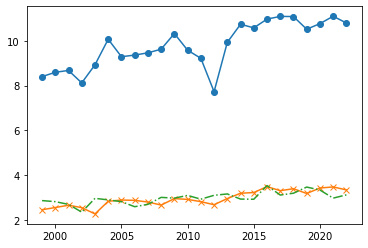

In [ ]:
# plt.plot(dates, values, '-o')

plt.plot(yield_df[yield_df['CMDTY_CODE'] == 'CORN']['YYYY'], yield_df[yield_df['CMDTY_CODE'] == 'CORN']['YLD'], '-o')
plt.plot(yield_df[yield_df['CMDTY_CODE'] == 'CORN']['YYYY'], yield_df[yield_df['CMDTY_CODE'] == 'SB']['YLD'], '-x')
plt.plot(yield_df[yield_df['CMDTY_CODE'] == 'CORN']['YYYY'], yield_df[yield_df['CMDTY_CODE'] == 'WHEAT']['YLD'], '-.')

In [ ]:
# put labels in data structure
for year in range(2000, 2023): # until 2022
  # only for corn
  # yield_val = yield_df[(yield_df['CMDTY_CODE'] == 'CORN') & (yield_df['YYYY'] == year)]['YLD'].item() # yield is keyword for use in lambdas
  # print('year, yield', year, yield_val)
  # modis_per_year[year]['label'] = yield_val

  # for all crops
  yield_corn = yield_df[(yield_df['CMDTY_CODE'] == 'CORN') & (yield_df['YYYY'] == year)]['YLD'].item()
  yield_soybean = yield_df[(yield_df['CMDTY_CODE'] == 'SB') & (yield_df['YYYY'] == year)]['YLD'].item()
  yield_wheat = yield_df[(yield_df['CMDTY_CODE'] == 'WHEAT') & (yield_df['YYYY'] == year)]['YLD'].item()
  print('year, yield (corn, soybean, wheat)', year, yield_corn, yield_soybean, yield_wheat)
  modis_per_year[year]['yield_corn'] = yield_corn
  modis_per_year[year]['yield_soybean'] = yield_soybean
  modis_per_year[year]['yield_wheat'] = yield_wheat

year, yield (corn, soybean, wheat) 2000 8.591008323 2.561341842 2.823926609
year, yield (corn, soybean, wheat) 2001 8.673266259 2.663957741 2.701926998
year, yield (corn, soybean, wheat) 2002 8.118009766 2.556752335 2.356827006
year, yield (corn, soybean, wheat) 2003 8.924730059 2.276951926 2.971267579
year, yield (corn, soybean, wheat) 2004 10.06362843 2.840494487 2.902680249
year, yield (corn, soybean, wheat) 2005 9.285272542 2.896129569 2.823189978
year, yield (corn, soybean, wheat) 2006 9.357832505 2.881782047 2.598711653
year, yield (corn, soybean, wheat) 2007 9.458416633 2.806695173 2.704636853
year, yield (corn, soybean, wheat) 2008 9.621052963 2.671861558 3.014640385
year, yield (corn, soybean, wheat) 2009 10.31803911 2.959523732 2.980515617
year, yield (corn, soybean, wheat) 2010 9.575788835 2.924329904 3.102724925
year, yield (corn, soybean, wheat) 2011 9.214582413 2.823251608 2.933852561
year, yield (corn, soybean, wheat) 2012 7.726892182 2.686798209 3.106527468
year, yield 

In [ ]:
modis_per_year[2000].keys()

dict_keys(['observations', 'yield_corn', 'yield_soybean', 'yield_wheat'])

## 4 save data
2 GB with just observations, label, bins_5

In [ ]:
# delete heaviest data - observations
for year in tqdm(range(2000, 2023)):
  modis_per_year[year].pop('observations')

100%|██████████| 23/23 [00:00<00:00, 131608.45it/s]


In [ ]:
modis_per_year[2000].keys()

dict_keys(['yield_corn', 'yield_soybean', 'yield_wheat', 'avg', 'bins_5', 'bins_10', 'bins_20', 'bins_5_numpy', 'bins_10_numpy', 'bins_20_numpy'])

In [ ]:
# import json
import pickle
path = '/content/drive/Shareddrives/CSCI 8523 F22/Data/'

# save
# Object of type ndarray is not JSON serializable
"""
with open('modis_per_year.json', 'w') as outfile:
    json.dump(modis_per_year, outfile)
"""
with open(path + 'modis_per_year.pkl', 'wb') as outp:
    pickle.dump(modis_per_year, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
# load
"""
with open('modis_per_year.json', 'r') as read_content:
    modis_per_year_loaded = json.load(read_content)
"""
with open(path + 'modis_per_year.pkl', 'rb') as inp:
    modis_per_year_loaded = pickle.load(inp)

In [ ]:
modis_per_year_loaded[2000].keys()

dict_keys(['yield_corn', 'yield_soybean', 'yield_wheat', 'avg', 'bins_5', 'bins_10', 'bins_20', 'bins_5_numpy', 'bins_10_numpy', 'bins_20_numpy'])

## LSTM

In [ ]:
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

NameError: ignored

In [ ]:
x = np.array( [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7 ,7, 7, 8, 8, 9, 10, 11, 1, 11] )
# x = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 6, 6, 7, 7 ,7, 7, 8, 8, 9, 10, 11, 1, 11]

In [ ]:
x.nonzero()

(array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25]),)

In [ ]:
hist = np.histogram(x, bins = 10, range = (0,1), density = False)

In [ ]:
x = modis_array[ modis_array[:, :, 2].nonzero() ] # .shape
x

array([[0.6468, 0.6042, 0.71  , ..., 0.7276, 0.6856, 0.6265],
       [0.6708, 0.6522, 0.7151, ..., 0.6961, 0.6506, 0.5872],
       [0.6444, 0.6929, 0.7422, ..., 0.6836, 0.6405, 0.6104],
       ...,
       [0.2968, 0.3213, 0.3594, ..., 0.4369, 0.5526, 0.4738],
       [0.277 , 0.2945, 0.3577, ..., 0.4499, 0.5976, 0.5589],
       [0.2823, 0.3139, 0.3373, ..., 0.4714, 0.5821, 0.4318]])

In [ ]:
b = np.expand_dims(x, axis=-1)
b

array([[0.6468],
       [0.6042],
       [0.6708],
       ...,
       [0.2945],
       [0.2823],
       [0.3139]])

In [ ]:
h, w = modis_array[:, :, 2].shape
count = 0

for i in range(h):
  for j in range(w):
    if modis_array[i, j, 2] > 0:
      count += 1

In [ ]:
count

64412

In [ ]:
h, w, h*w

(460, 1115, 512900)

In [ ]:
y.shape

(20614098,)

In [ ]:
hist

(array([3841282,  686326, 6245727, 6179249, 4767786, 3567224, 3090031,
        3062324, 2018441,   35850]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
get_bins_from_observation( modis_array[:, :, 2] , 10, max_val=1, min_val=0)

array([4.4000e+01, 2.0450e+03, 2.8522e+04, 1.6553e+04, 9.8880e+03,
       5.0520e+03, 2.0090e+03, 2.9500e+02, 4.0000e+00, 0.0000e+00])

In [ ]:
modis_array[:, :, 2].shape

(460, 1115)